# Playground - RSA (Respiratory sinus arrhythmia)
Very helpful - official repo of the physio library (processing ECG and Respiratory signals) - https://github.com/samuelgarcia/physio_benchmark/tree/main

Dataset is Zenodo

In [157]:
import os
import numpy as np
import tqdm
import neurokit2 as nk
import matplotlib.pyplot as plt
from customLib.vis import plot_ecg
from customLib.preprocess import myConv1D
from customLib.preprocess import dwt_denoise
from customLib.preprocess import resample_signal
from customLib.preprocess import split_signal
from customLib.create_dataset import label_ecgs
from customLib.peak_detection import group_peaks


In [158]:
path = "E:\\ml-data\\masters-thesis\\RSA\\Zenodo\\human"

In [159]:
sample_data = np.loadtxt(path +"\\S00.txt")
sample_data.shape
raw_ecg = sample_data[:, 0]
raw_resp = sample_data[:, 1]

srate = 1000
times = np.arange(raw_ecg.size) / srate

[]

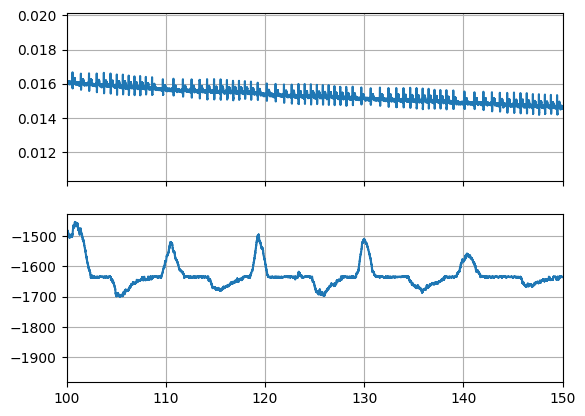

In [160]:
fig, axs = plt.subplots(sharex=True, nrows=2)
ax = axs[0]
ax.plot(times, raw_ecg)
ax.grid()

ax = axs[1]
ax.plot(times, raw_resp)
ax.grid()

ax.set_xlim(100, 150)
plt.plot()


[]

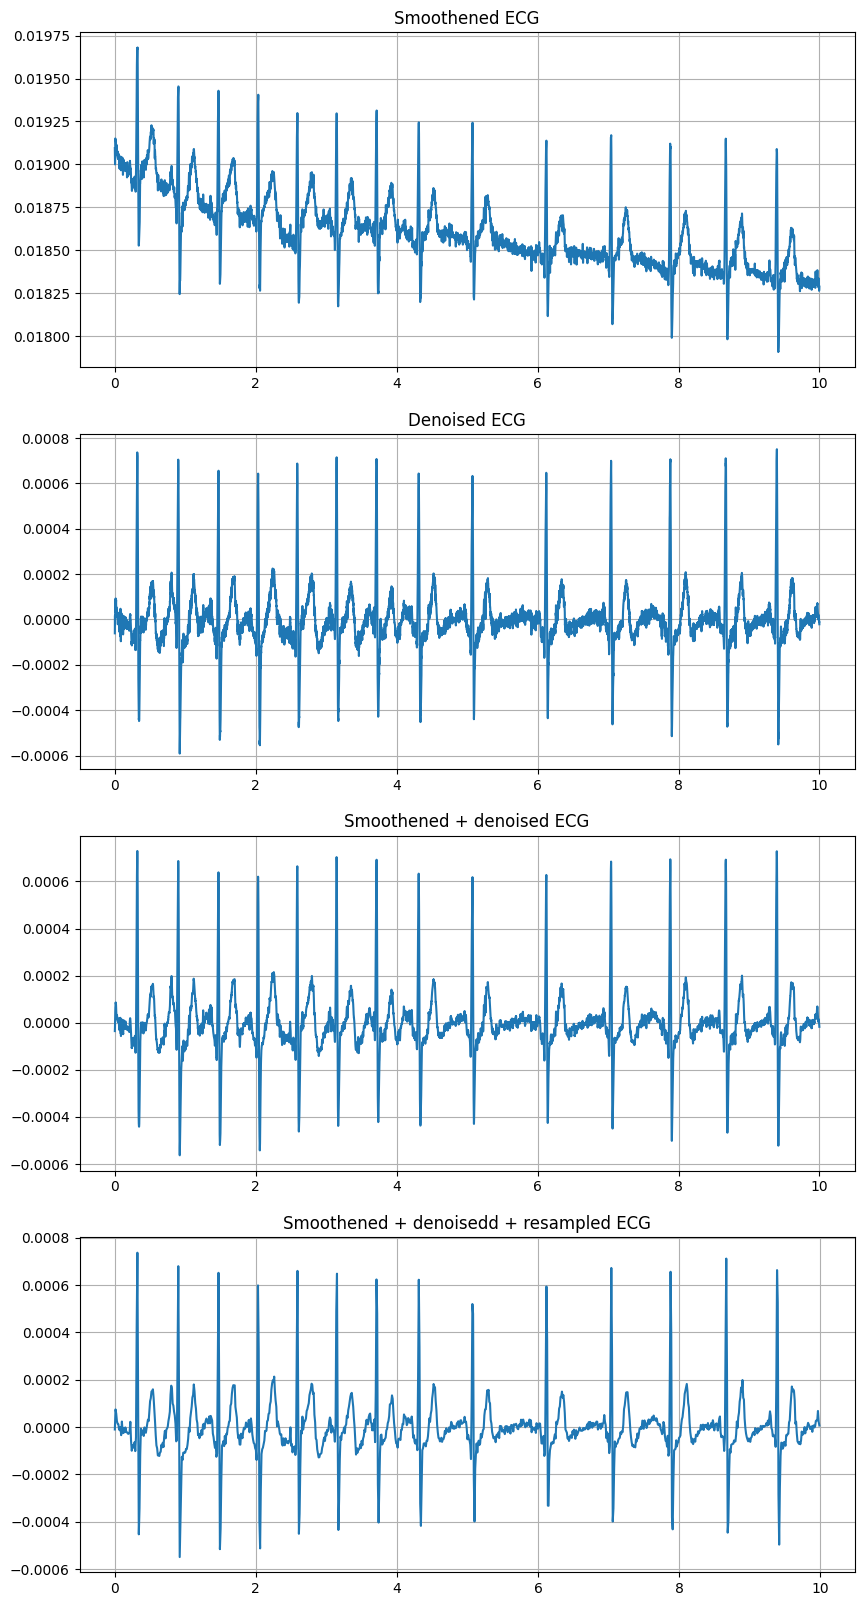

In [161]:
ecg_sample = raw_ecg[:10000]
smoothened_ecg = myConv1D(signal=ecg_sample, kernel_length=5, padding="same")
denoised_ecg = dwt_denoise(signal=ecg_sample)
smoothened_denoised = myConv1D(signal=denoised_ecg, kernel_length=5, padding="same")
smoothened_denoised_downsampled = resample_signal(smoothened_denoised, 1000)
time_resampled = times[:10000:10]

fig, axs = plt.subplots(nrows=4)
ax = axs[0]
ax.set_title("Smoothened ECG")
ax.plot(times[:10000], smoothened_ecg)
ax.grid()

ax = axs[1]
ax.set_title("Denoised ECG")
ax.plot(times[:10000], denoised_ecg)
ax.grid()

ax = axs[2]
ax.set_title("Smoothened + denoised ECG")
ax.plot(times[:10000], smoothened_denoised)
ax.grid()


ax = axs[3]
ax.set_title("Smoothened + denoisedd + resampled ECG")
ax.plot(time_resampled, smoothened_denoised_downsampled)
ax.grid()

fig.set_size_inches(10, 20)
plt.plot()

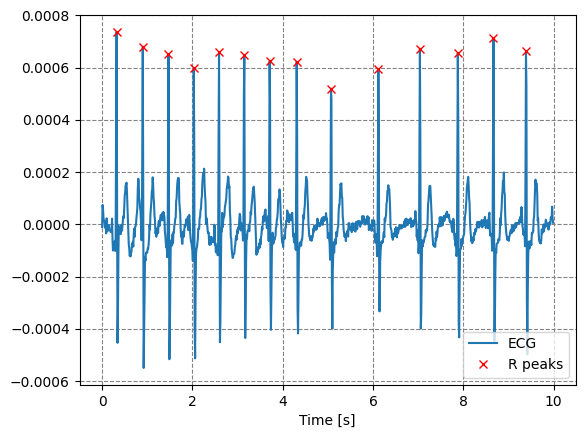

In [162]:
_, r_peaks = nk.ecg_peaks(ecg_cleaned=smoothened_denoised_downsampled, sampling_rate=100)
r_peaks = r_peaks["ECG_R_Peaks"]
plot_ecg(smoothened_denoised_downsampled, r_peaks, 100)

### Test pretrained ST_RES_NET for R-peak detection

In [163]:
import torch
from models.models import ST_RES_NET

In [164]:
model = ST_RES_NET()
model.load_state_dict(torch.load("./checkpoints/st_res_net.pt"))

Training will be performed with: cuda:0


<All keys matched successfully>

In [165]:
smoothened_ecg = myConv1D(raw_ecg, 5, "same")
resampled_ecg = smoothened_ecg[::10]
ecgs = split_signal(signal=resampled_ecg, window_in_seconds=10, fs=100, normalize=False)
ecgs = [dwt_denoise(ecg) for ecg in ecgs]
ecgs = np.array(ecgs)

x, y = label_ecgs(ecgs=ecgs, sampling_rate=100)

Total ECGs: 33


100%|██████████| 33/33 [00:00<00:00, 845.61it/s]


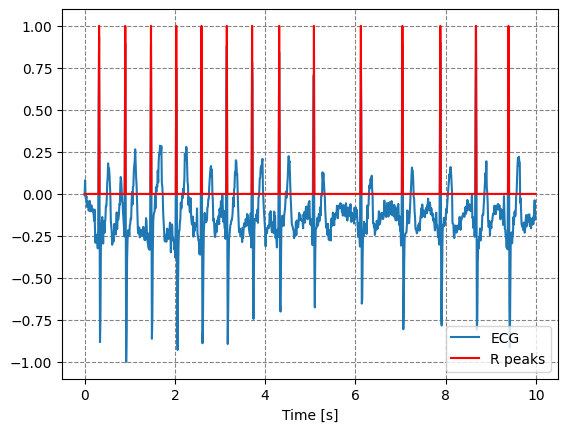

In [166]:
plot_ecg(x[0], y[0], 100)

In [167]:
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

In [168]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_tensor = torch.from_numpy(x)
x_tensor = x_tensor.to(device)
x_tensor = x_tensor.float()

predictions = model.forward(x_tensor)
predictions = predictions.cpu().detach().numpy()

In [169]:
def peaks_to_rri(r_peaks: np.ndarray, sampling_rate=100):
  if np.max(r_peaks) > 1: # passed as indices vector
    indices = r_peaks
  else:
    indices = np.where(r_peaks == 1)[0]

  indices_seconds = indices * 1 / sampling_rate

  rri = np.diff(indices_seconds)
  return rri

C:\Users\patry\AppData\Local\Temp\ipykernel_20624\3399108945.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=2)


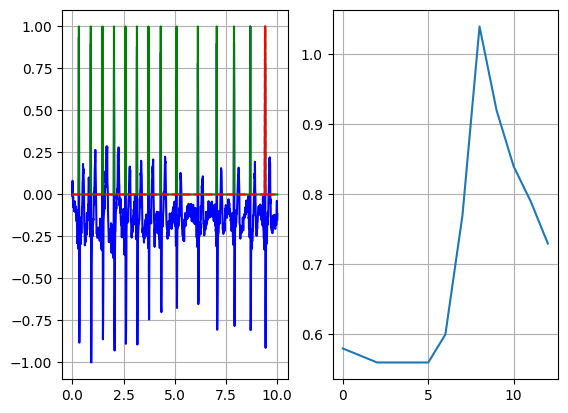

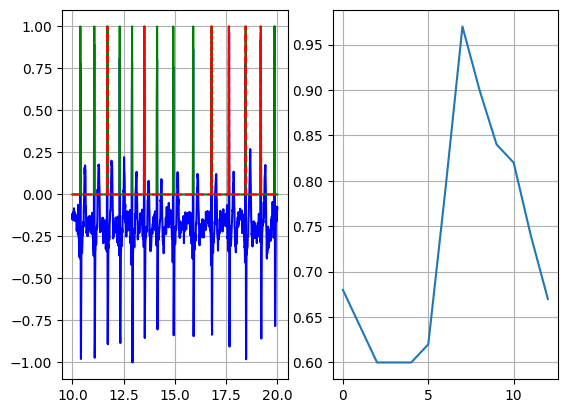

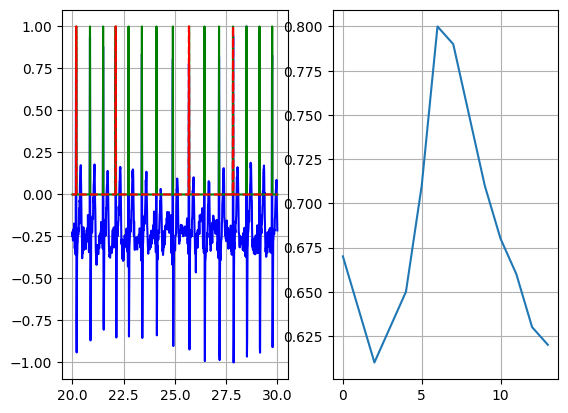

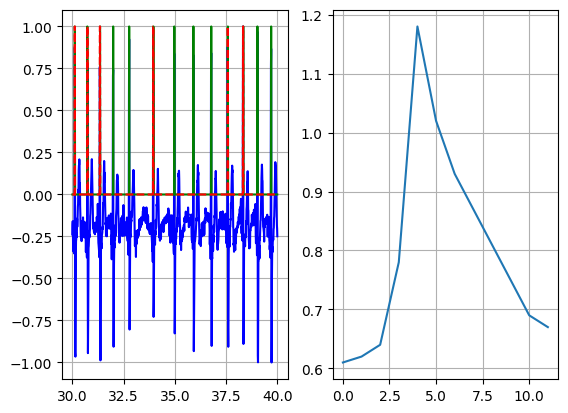

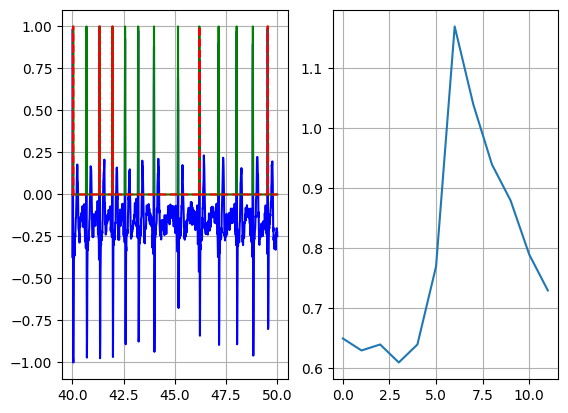

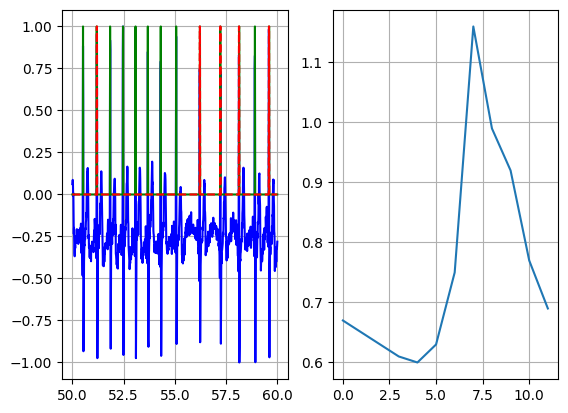

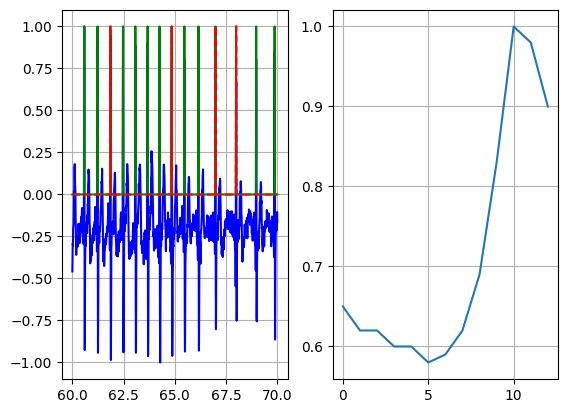

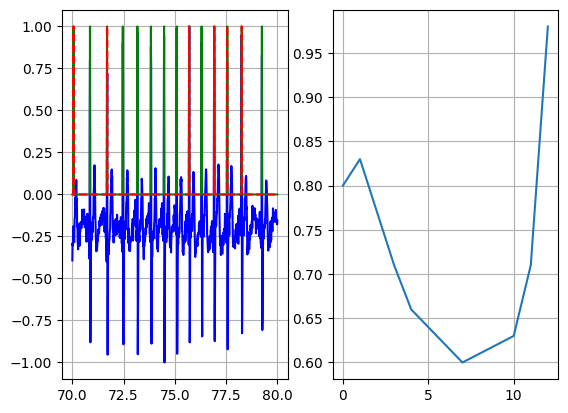

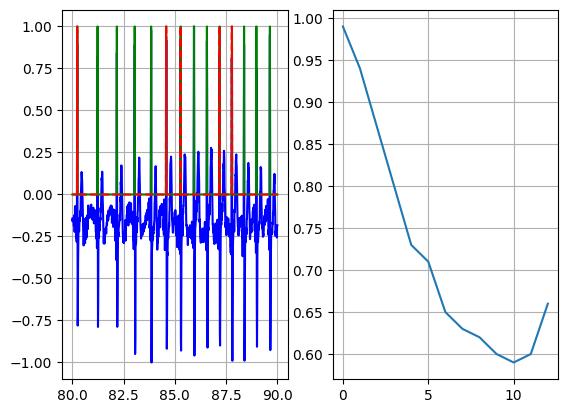

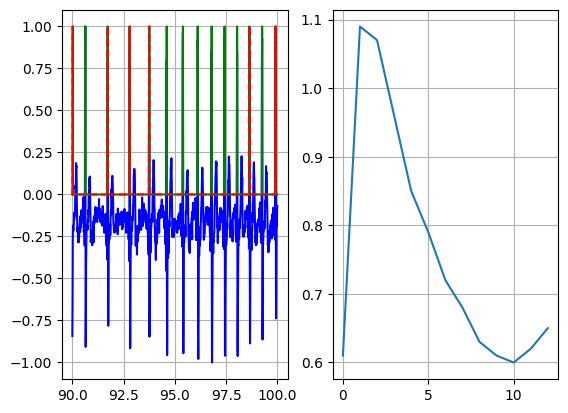

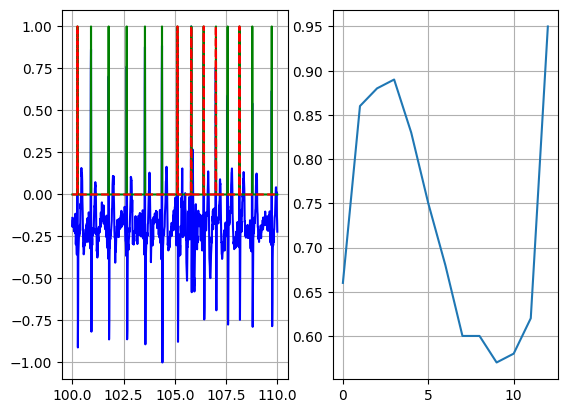

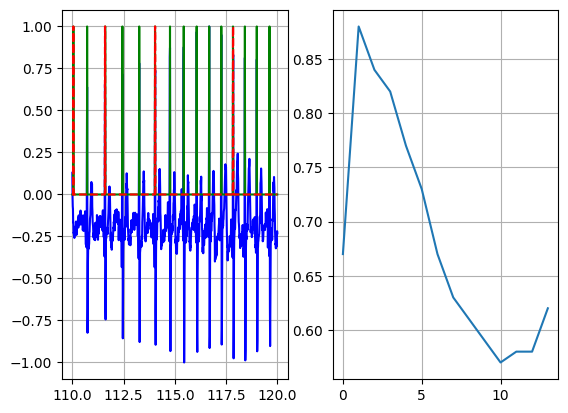

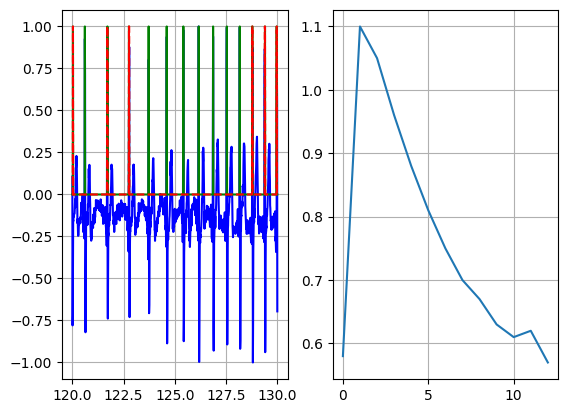

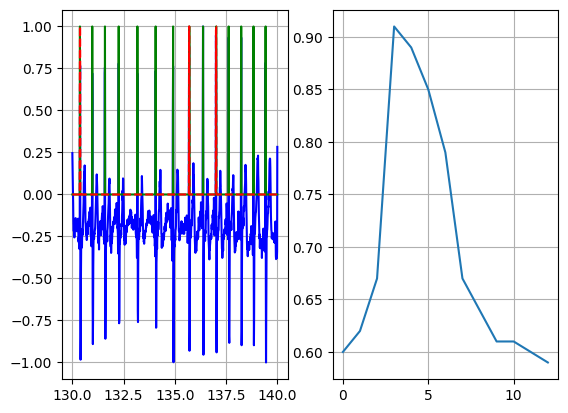

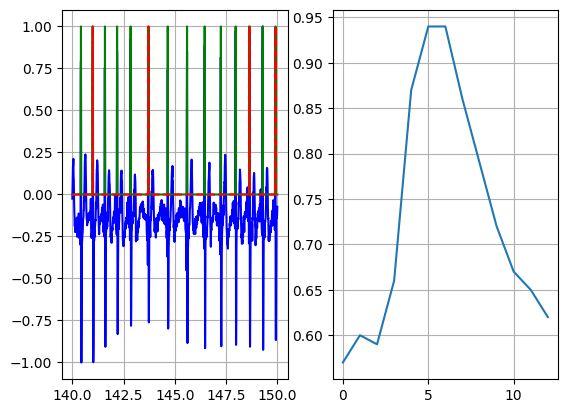

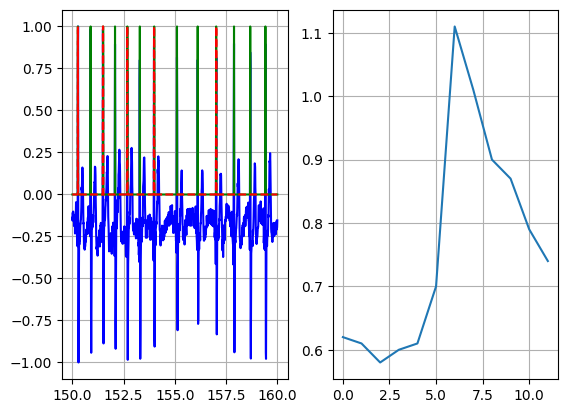

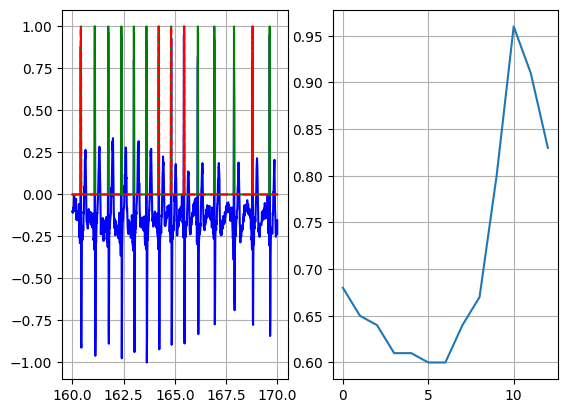

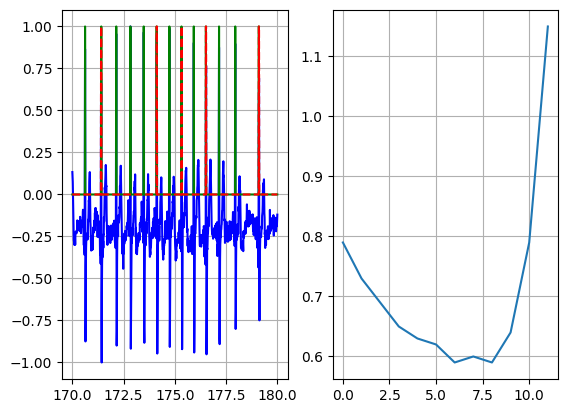

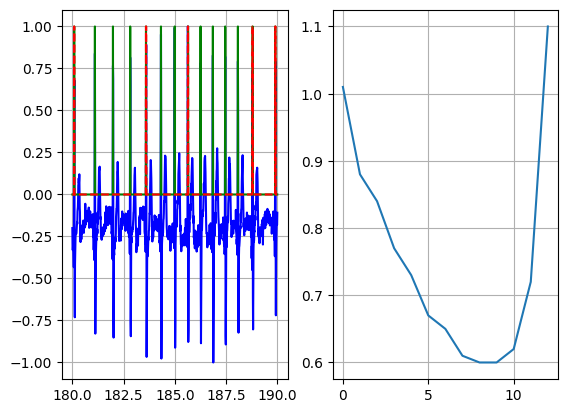

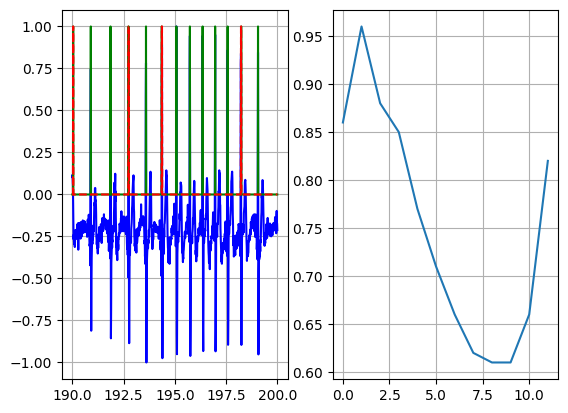

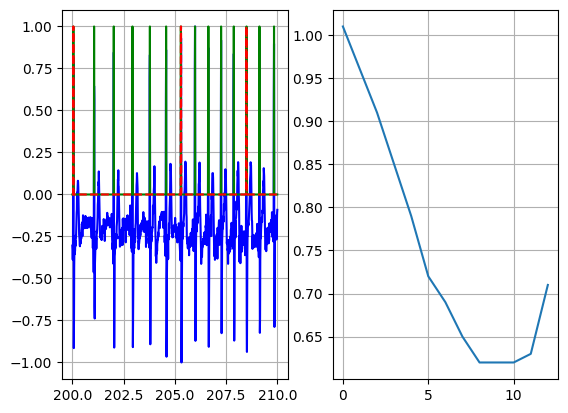

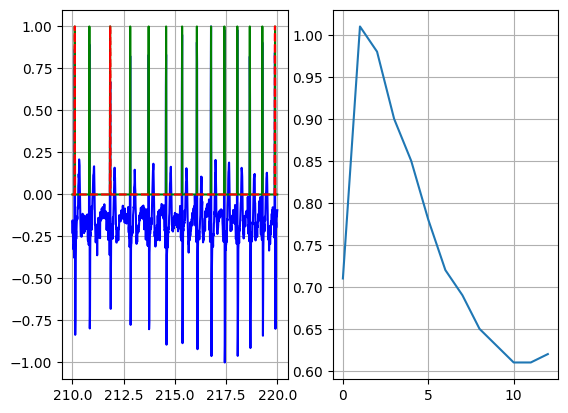

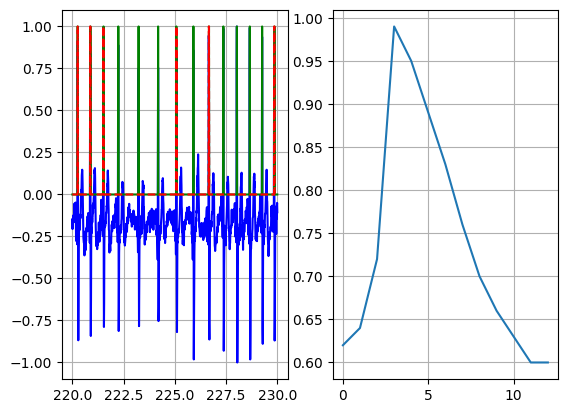

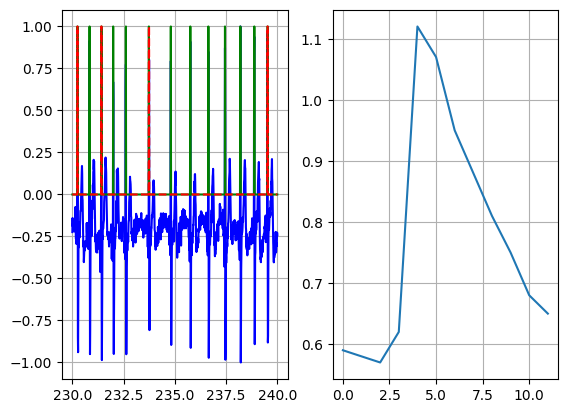

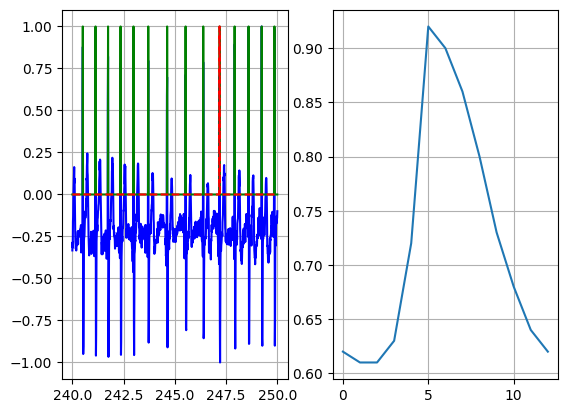

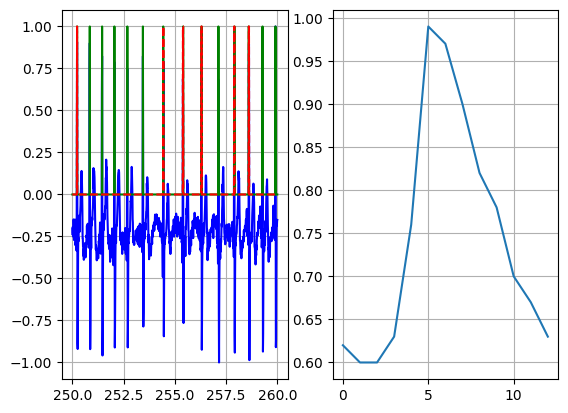

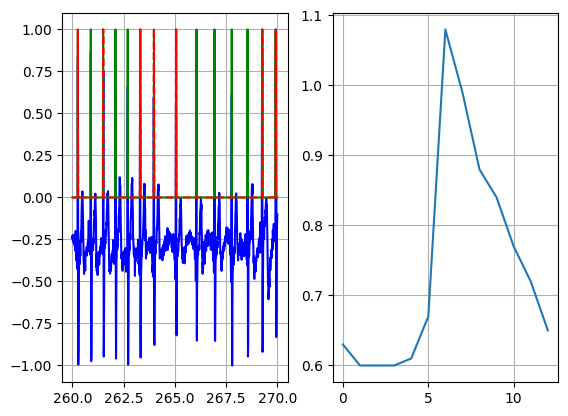

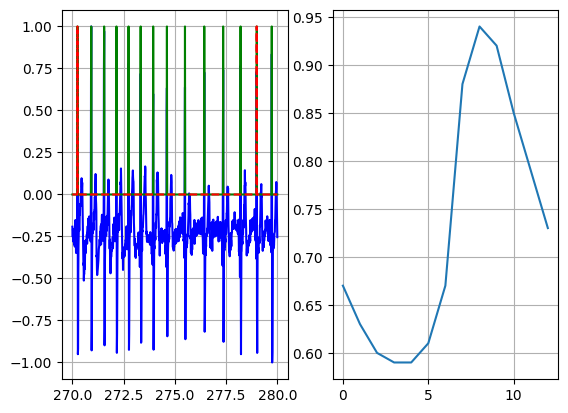

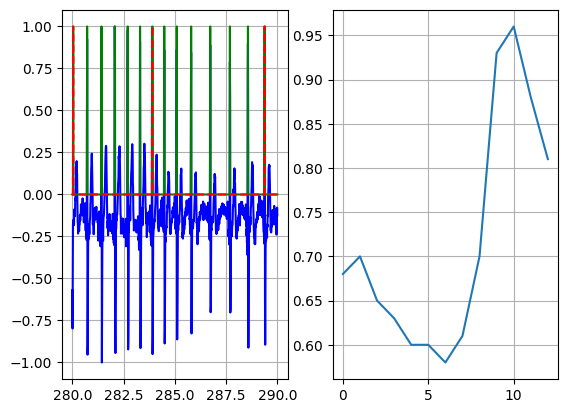

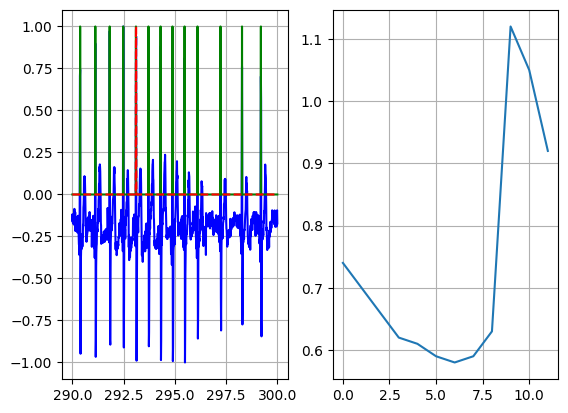

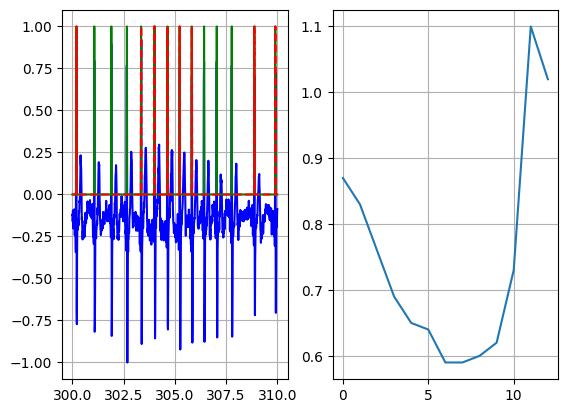

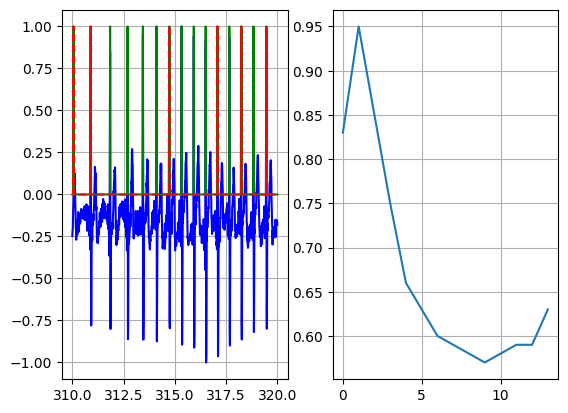

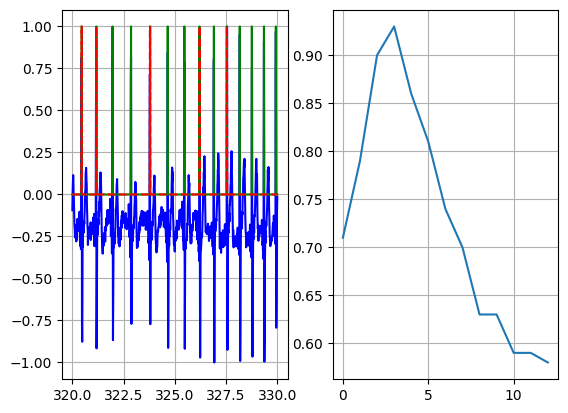

In [174]:
whole = None

times = np.linspace(start=0, stop=10, num=1000)

for i in range(x.shape[0]):
  ecg = x[i].flatten()
  gt = y[i].flatten()

  prediction = predictions[i].flatten()
  prediction = group_peaks(indices=np.where(prediction > 0.5)[0])
  r_peaks = np.zeros_like(ecg)
  r_peaks[prediction] = 1

  if whole is None:
    whole = np.array(prediction)
  else:
    whole = np.concatenate((whole, prediction + i * 1000))

  error = np.zeros_like(ecg)
  error_indices = np.where(r_peaks != gt)[0]
  error[error_indices] = 1

  fig, axs = plt.subplots(ncols=2)
  ax = axs[0]
  ax.plot(times, ecg, "b-")
  ax.plot(times, r_peaks, "g-")
  ax.plot(times, error, "r--")
  ax.grid()

  ax = axs[1]
  ax.plot(peaks_to_rri(r_peaks))
  ax.grid()

  times += 10

In [171]:
all_r_peaks = np.zeros_like(raw_ecg)
all_r_peaks[whole] = 1
whole_ecg = x.flatten()

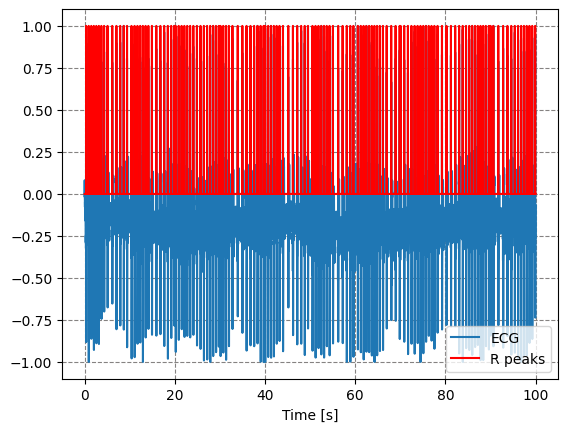

Text(0.5, 1.0, 'Heart Rate [BPM]')

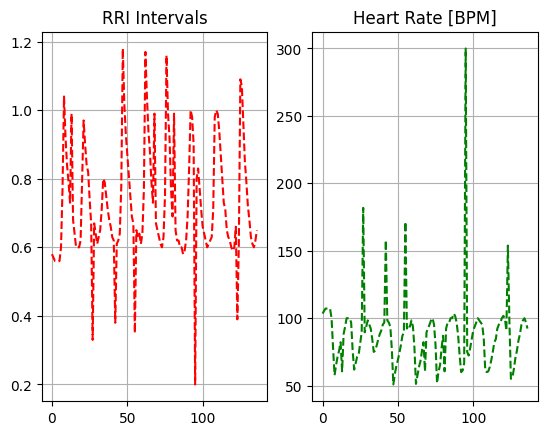

In [173]:
length = 10000

ecg = whole_ecg[:length]
r_peaks = all_r_peaks[:length]
plot_ecg(ecg, r_peaks, 100)

rri_indices = [x for x in range(len(peaks_to_rri(all_r_peaks[:length])))]
rris = peaks_to_rri(all_r_peaks[:length])

fig, axs = plt.subplots(ncols=2)
ax = axs[0]
ax.grid()
ax.plot(rri_indices, rris, "r--")
ax.set_title("RRI Intervals")

bpm = 60 / rris

ax = axs[1]
ax.grid()
ax.plot(rri_indices, bpm, "g--")
ax.set_title("Heart Rate [BPM]")